
# Loan Approval Classification

## 1. Create a normalized database (3NF):

In [1]:
import sqlite3

# Step 1: Create SQLite database and define schema
connection = sqlite3.connect("loan_data.db")
cursor = connection.cursor()

# Create Person Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Person (
    person_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_age INTEGER,
    person_gender TEXT,
    person_education TEXT,
    person_income REAL,
    person_emp_exp INTEGER,
    person_home_ownership TEXT
);
""")

# Create Loan Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Loan (
    loan_id INTEGER PRIMARY KEY AUTOINCREMENT,
    loan_amnt REAL,
    loan_intent TEXT,
    loan_int_rate REAL,
    loan_percent_income REAL
);
""")

# Create Credit Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Credit (
    credit_id INTEGER PRIMARY KEY AUTOINCREMENT,
    cb_person_cred_hist_length INTEGER,
    credit_score INTEGER,
    previous_loan_defaults_on_file TEXT
);
""")

# Create Loan Status Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS LoanStatus (
    status_id INTEGER PRIMARY KEY AUTOINCREMENT,
    loan_id INTEGER,
    credit_id INTEGER,
    loan_status INTEGER,
    FOREIGN KEY (loan_id) REFERENCES Loan(loan_id),
    FOREIGN KEY (credit_id) REFERENCES Credit(credit_id)
);
""")

connection.commit()

# Step 2: Insert data into normalized tables
def insert_data():
    with open("loan_data.csv", "r") as file:
        next(file)  # Skip header row
        for line in file:
            # Split the CSV row into individual fields
            fields = line.strip().split(",")
            
            # Extract data for each table
            person_data = (fields[0], fields[1], fields[2], fields[3], fields[4], fields[5])
            loan_data = (fields[6], fields[7], fields[8], fields[9])
            credit_data = (fields[10], fields[11], fields[12])
            loan_status = fields[13]
            
            # Insert data into Person table
            cursor.execute("""
                INSERT INTO Person (person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership)
                VALUES (?, ?, ?, ?, ?, ?);
            """, person_data)
            person_id = cursor.lastrowid
            
            # Insert data into Loan table
            cursor.execute("""
                INSERT INTO Loan (loan_amnt, loan_intent, loan_int_rate, loan_percent_income)
                VALUES (?, ?, ?, ?);
            """, loan_data)
            loan_id = cursor.lastrowid
            
            # Insert data into Credit table
            cursor.execute("""
                INSERT INTO Credit (cb_person_cred_hist_length, credit_score, previous_loan_defaults_on_file)
                VALUES (?, ?, ?);
            """, credit_data)
            credit_id = cursor.lastrowid
            
            # Insert data into LoanStatus table
            cursor.execute("""
                INSERT INTO LoanStatus (loan_id, credit_id, loan_status)
                VALUES (?, ?, ?);
            """, (loan_id, credit_id, loan_status))
    
    connection.commit()

# Call the function to insert data
insert_data()

# Step 3: Verify Data Integrity with Queries
def verify_data():
    print("Person Table:")
    for row in cursor.execute("SELECT * FROM Person LIMIT 5;"):
        print(row)

    print("\nLoan Table:")
    for row in cursor.execute("SELECT * FROM Loan LIMIT 5;"):
        print(row)

    print("\nCredit Table:")
    for row in cursor.execute("SELECT * FROM Credit LIMIT 5;"):
        print(row)

    print("\nLoanStatus Table:")
    for row in cursor.execute("""
        SELECT * FROM LoanStatus 
        JOIN Loan ON LoanStatus.loan_id = Loan.loan_id 
        JOIN Credit ON LoanStatus.credit_id = Credit.credit_id 
        LIMIT 5;
    """):
        print(row)

verify_data()

# Close the connection
connection.close()


Person Table:
(1, 22, 'female', 'Master', 71948.0, 0, 'RENT')
(2, 21, 'female', 'High School', 12282.0, 0, 'OWN')
(3, 25, 'female', 'High School', 12438.0, 3, 'MORTGAGE')
(4, 23, 'female', 'Bachelor', 79753.0, 0, 'RENT')
(5, 24, 'male', 'Master', 66135.0, 1, 'RENT')

Loan Table:
(1, 35000.0, 'PERSONAL', 16.02, 0.49)
(2, 1000.0, 'EDUCATION', 11.14, 0.08)
(3, 5500.0, 'MEDICAL', 12.87, 0.44)
(4, 35000.0, 'MEDICAL', 15.23, 0.44)
(5, 35000.0, 'MEDICAL', 14.27, 0.53)

Credit Table:
(1, 3, 561, 'No')
(2, 2, 504, 'Yes')
(3, 3, 635, 'No')
(4, 2, 675, 'No')
(5, 4, 586, 'No')

LoanStatus Table:
(1, 1, 1, 1, 1, 35000.0, 'PERSONAL', 16.02, 0.49, 1, 3, 561, 'No')
(2, 2, 2, 0, 2, 1000.0, 'EDUCATION', 11.14, 0.08, 2, 2, 504, 'Yes')
(3, 3, 3, 1, 3, 5500.0, 'MEDICAL', 12.87, 0.44, 3, 3, 635, 'No')
(4, 4, 4, 1, 4, 35000.0, 'MEDICAL', 15.23, 0.44, 4, 2, 675, 'No')
(5, 5, 5, 1, 5, 35000.0, 'MEDICAL', 14.27, 0.53, 5, 4, 586, 'No')


## 2. Write SQL join statement to fetch data from the database and into Pandas DataFrame.

In [2]:
import sqlite3
import pandas as pd

# Step 1: Connect to the SQLite database
connection = sqlite3.connect("loan_data.db")
cursor = connection.cursor()

# Step 2: Define the SQL JOIN query to combine all normalized tables
query = """
SELECT 
    Person.person_age,
    Person.person_gender,
    Person.person_education,
    Person.person_income,
    Person.person_emp_exp,
    Person.person_home_ownership,
    Loan.loan_amnt,
    Loan.loan_intent,
    Loan.loan_int_rate,
    Loan.loan_percent_income,
    Credit.cb_person_cred_hist_length,
    Credit.credit_score,
    Credit.previous_loan_defaults_on_file,
    LoanStatus.loan_status
FROM 
    LoanStatus
INNER JOIN 
    Loan ON LoanStatus.loan_id = Loan.loan_id
INNER JOIN 
    Credit ON LoanStatus.credit_id = Credit.credit_id
INNER JOIN 
    Person ON LoanStatus.status_id = Person.person_id;
"""

# Step 3: Execute the query and fetch the results into a Pandas DataFrame
df = pd.read_sql_query(query, connection)

# Step 4: Display the DataFrame (optional)
print(df.head())

# Step 5: Save the DataFrame to a CSV file
output_file = "normalized_loan_data.csv"
df.to_csv(output_file, index=False)

print(f"Data successfully written to {output_file}")

# Step 6: Close the database connection
connection.close()


   person_age person_gender person_education  person_income  person_emp_exp  \
0          22        female           Master        71948.0               0   
1          21        female      High School        12282.0               0   
2          25        female      High School        12438.0               3   
3          23        female         Bachelor        79753.0               0   
4          24          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                           3           561  

Drop rows with even a single null value to make sure our data is full filled.

In [3]:
df_cleaned = df.dropna()

In [4]:
df.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0          22        female           Master        71948.0               0   
1          21        female      High School        12282.0               0   
2          25        female      High School        12438.0               3   
3          23        female         Bachelor        79753.0               0   
4          24          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                           3           561   
1                 0.08                           2           504   
2                 0.44                           3           635   
3                 0.44                           2           675   
4                 0.53                           4           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

## 3. Explore the data to determine if you need to stratify it by some attribute when doing train/test split. Perform the train/test split.


Loan Status Distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


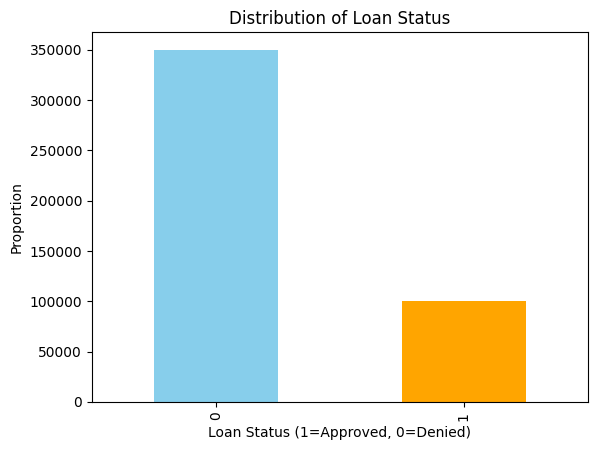

In [5]:

# Analyze the distribution of the target variable
print("Loan Status Distribution:")
print(df["loan_status"].value_counts(normalize=True))

# Visualize the distribution
import matplotlib.pyplot as plt

df["loan_status"].value_counts().plot(kind="bar", color=["skyblue", "orange"])
plt.title("Distribution of Loan Status")
plt.xlabel("Loan Status (1=Approved, 0=Denied)")
plt.ylabel("Proportion")
plt.show()

Lets stratify on Loan_status!

In [7]:
!pip install scikit-learn==1.5.2

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.0 MB 15.1 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/11.0 MB 13.9 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 15.0 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


## Explore the data using yprofile and correlation matrix. Make observations about features, distributions, capped values, and missing values. Create a list of data cleanup tasks.	

In [ ]:
import pandas as pd

# since yprofile causes problems this part was done later!

# from ydata_profiling import ProfileReport

# # Generate a profiling report
# profile = ProfileReport(df, title="Loan Data Profiling Report", explorative=True)
# profile



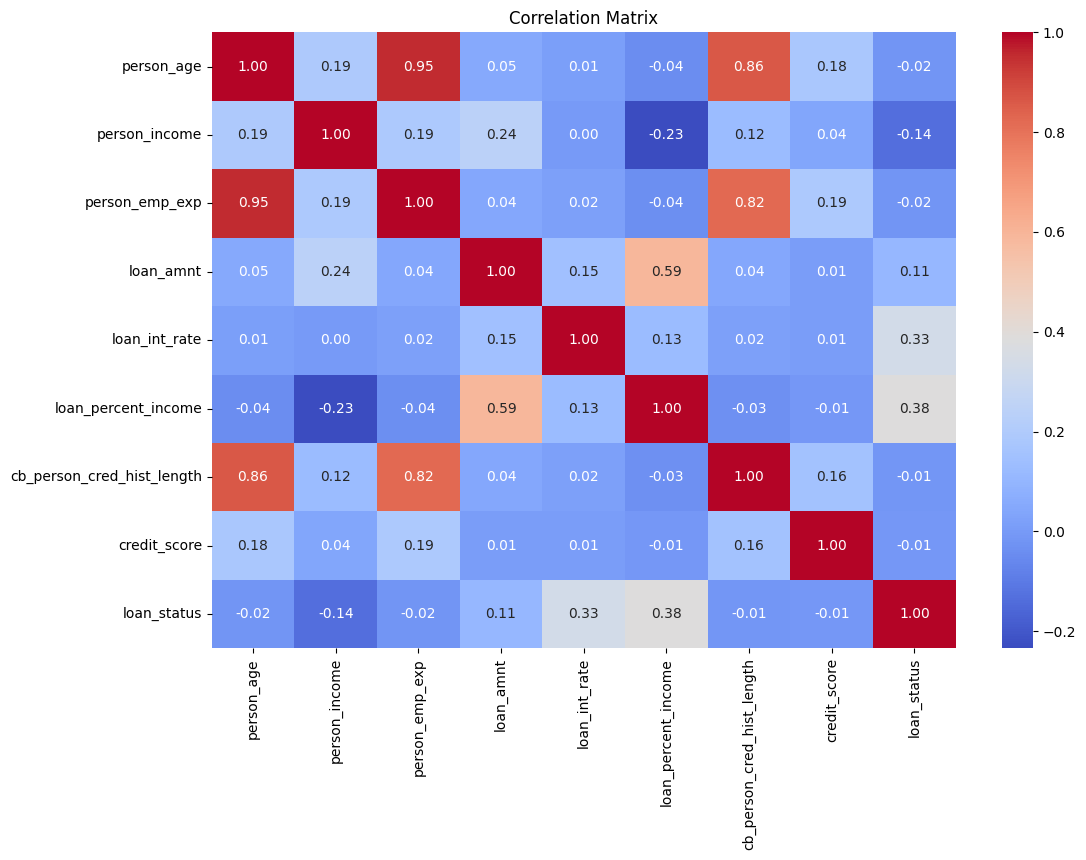

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numerical features
numerical_columns = df.select_dtypes(include=['number'])

correlation_matrix = numerical_columns.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()


## Explore the data to determine if you need to stratify it by some attribute when doing train/test split. Perform the train/test split.

In [10]:
from sklearn.model_selection import train_test_split

In [12]:

# Step 1: Load the cleaned dataset
df = pd.read_csv("normalized_loan_data.csv")  # Ensure this is the cleaned dataset without missing values

# Step 2: Separate features (X) and target variable (y)
X = df.drop(columns=["loan_status"])  # Features
y = df["loan_status"]                 # Target variable

# Step 3: Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Combine X_train and y_train into a single DataFrame for training data
loan = X_train.copy()
loan["loan_status"] = y_train

# Combine X_test and y_test into a single DataFrame for testing data
loan_labels = X_test.copy()
loan_labels["loan_status"] = y_test

# Step 5: Save the train and test datasets (optional)
loan.to_csv("loan_train.csv", index=False)
loan_labels.to_csv("loan_test.csv", index=False)

# Print confirmation
print(f"Training data shape: {loan.shape}")
print(f"Testing data shape: {loan_labels.shape}")

Training data shape: (360000, 14)
Testing data shape: (90000, 14)


In [13]:
loan.head()

person_age person_gender person_education  person_income  \
18066           27        female        Associate        87487.0   
104996          25        female           Master        30646.0   
167035          38        female        Associate        64338.0   
157090          28          male      High School        74263.0   
65771           28        female      High School        42787.0   

        person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
18066                5                  RENT    25000.0  DEBTCONSOLIDATION   
104996               3                   OWN     8500.0          EDUCATION   
167035              14                  RENT     8000.0          EDUCATION   
157090               6                  RENT     6300.0            VENTURE   
65771                8                  RENT     5000.0    HOMEIMPROVEMENT   

        loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
18066           15.95                 0.29                           6   
104996           6.03                 0.28                           2   
167035          11.01                 0.12                          15   
157090          13.61                 0.08                           9   
65771            8.90                 0.12                           9   

        credit_score previous_loan_defaults_on_file  loan_status  
18066            637                             No            1  
104996           522                            Yes            0  
167035           580                             No            0  
157090           602                            Yes            0  
65771            594                             No            1

In [14]:
loan_labels.head()

person_age person_gender person_education  person_income  \
252385          35          male         Bachelor       164214.0   
397104          28        female           Master       105305.0   
1483            25        female           Master        52595.0   
343957          29          male        Associate       190348.0   
317160          26          male         Bachelor        81365.0   

        person_emp_exp person_home_ownership  loan_amnt loan_intent  \
252385              10              MORTGAGE    15000.0   EDUCATION   
397104               8              MORTGAGE     8115.0   EDUCATION   
1483                 2                  RENT     1200.0     VENTURE   
343957               5                   OWN    11000.0     VENTURE   
317160               4                  RENT     2400.0     MEDICAL   

        loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
252385          11.01                 0.09                           9   
397104           9.68                 0.08                          10   
1483             9.91                 0.02                           4   
343957           8.49                 0.06                           7   
317160          12.99                 0.03                           2   

        credit_score previous_loan_defaults_on_file  loan_status  
252385           628                             No            0  
397104           662                             No            0  
1483             611                            Yes            0  
343957           688                             No            0  
317160           698                            Yes            0

## Experiment #1: Create a pipeline for preprocessing (StandardScaler, MinMaxScaler, LogTransformation, OneHotEncoding) and Logistic Regression. Log F1-score/(TP,TN,FN,FP)  in MLFlow on DagsHub. – Cross validation 3/10 folds. Results—mean/std of CV results and results on the whole training data – add in parameter hyper tuning.

In [15]:
!pip install dagshub mlflow

Defaulting to user installation because normal site-packages is not writeable


### Setup mlflow and dagshub

In [16]:
import mlflow
import mlflow.sklearn
import dagshub

dagshub.init(repo_owner='Vr1155', repo_name="Loan-Approval-Classification_fall2024", mlflow=True)


# Set MLFlow tracking URI to DagsHub
mlflow.set_tracking_uri("https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow")
mlflow.set_experiment("Loan_Classification_Experiment")

Accessing as Vr1155

Initialized MLflow to track repo "Vr1155/Loan-Approval-Classification_fall2024"

Repository Vr1155/Loan-Approval-Classification_fall2024 initialized!

<Experiment: artifact_location='mlflow-artifacts:/bb73773d19014241ac26a1f52d084981', creation_time=1734729285786, experiment_id='0', last_update_time=1734729285786, lifecycle_stage='active', name='Loan_Classification_Experiment', tags={}>

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
import mlflow.sklearn


In [18]:
# Load training data (loan) and testing data (loan_labels)
loan = pd.read_csv("loan_train.csv")
loan_labels = pd.read_csv("loan_test.csv")

# Separate features (X) and target variable (y)
X_train = loan.drop(columns=["loan_status"])
y_train = loan["loan_status"]
X_test = loan_labels.drop(columns=["loan_status"])
y_test = loan_labels["loan_status"]


### Define Preprocessing Pipelines:

In [19]:

# Define numerical and categorical columns
numerical_cols = ["person_income", "loan_amnt", "loan_int_rate", "credit_score"]
categorical_cols = ["person_gender", "person_home_ownership", "loan_intent"]

# Log transformation for numerical features
log_transformer = FunctionTransformer(np.log1p)

# Preprocessing for numerical features
numerical_preprocessor = make_pipeline(
    log_transformer,
    StandardScaler()
)

# Preprocessing for categorical features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_preprocessor, numerical_cols),
        ("cat", categorical_preprocessor, categorical_cols)
    ]
)

numerical_preprocessor
preprocessor



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['person_income', 'loan_amnt', 'loan_int_rate',
                                  'credit_score']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['person_gender', 'person_home_ownership',
                                  'loan_intent'])])

### Create Full Pipeline with Logistic Regression:

In [20]:
# Create a pipeline with preprocessing and Logistic Regression
pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['person_income', 'loan_amnt',
                                                   'loan_int_rate',
                                                   'credit_score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_gender',
                                                   'person_home_ownership',
                                                   'loan_intent'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

### Cross-Validation and logging in MLFlow

In [21]:
# Define scoring metrics for cross-validation (F1-score)
scoring_metrics = {
    "f1": make_scorer(f1_score),
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall"
}

# Perform cross-validation with 10 folds
cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=10,
    scoring=scoring_metrics,
    return_train_score=True,
)

# Log results to MLFlow on DagsHub
with mlflow.start_run():
    # Log parameters (e.g., preprocessing steps and model hyperparameters)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("log_transform", True)
    mlflow.log_param("model", "LogisticRegression")
    
    # Log cross-validation metrics (mean/std of F1-score)
    mean_f1 = np.mean(cv_results["test_f1"])
    std_f1 = np.std(cv_results["test_f1"])
    
    mlflow.log_metric("mean_cv_f1_score", mean_f1)
    mlflow.log_metric("std_cv_f1_score", std_f1)
    
    # Train the pipeline on the full training data and evaluate on test data
    pipeline.fit(X_train, y_train)
    
    # Predict on test data and calculate confusion matrix metrics
    y_pred = pipeline.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log confusion matrix metrics to MLFlow
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    
    # Log F1-score on test data to MLFlow
    test_f1_score = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1_score", test_f1_score)

print(f"Mean CV F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}")


🏃 View run gifted-crane-779 at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/fd2fc0e277a541a8bad5aa07f815a4ae
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
Mean CV F1-Score: 0.5683 ± 0.0031
Test F1-Score: 0.5673


### Hyperparameter Tuning

In [22]:
# Define hyperparameter grid for Logistic Regression
param_grid = {
    "logisticregression__C": [0.01, 0.1, 1.0, 10.0],   # Regularization strength
}

# Perform GridSearchCV with the pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="f1"
)

grid_search.fit(X_train, y_train)

# Log best hyperparameters to MLFlow on DagsHub
with mlflow.start_run():
    best_params = grid_search.best_params_
    
    # Log best parameters to MLFlow
    for param_name, param_value in best_params.items():
        mlflow.log_param(param_name, param_value)
    
    # Evaluate the best model on test data and log metrics
    best_model = grid_search.best_estimator_
    
    y_pred_best = best_model.predict(X_test)
    
    tn_best, fp_best, fn_best, tp_best = confusion_matrix(y_test, y_pred_best).ravel()
    
    # Log confusion matrix metrics for the best model to MLFlow
    mlflow.log_metric("best_true_positive", tp_best)
    mlflow.log_metric("best_true_negative", tn_best)
    mlflow.log_metric("best_false_positive", fp_best)
    mlflow.log_metric("best_false_negative", fn_best)

print(f"Best Hyperparameters: {best_params}")


🏃 View run respected-horse-333 at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/875a5e8f98bb4284bf0616b217ba9c7e
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
Best Hyperparameters: {'logisticregression__C': 10.0}


# Experiment #2: Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier, RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.	10		

### Import necessary libraries

In [23]:
!pip install xgboost
import xgboost
print(xgboost.__version__)


Defaulting to user installation because normal site-packages is not writeable
2.1.3


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')


### Create Preprocessing Pipeline

In [25]:
# Define numerical and categorical columns
numerical_cols = ["person_income", "loan_amnt", "loan_int_rate", "credit_score"]
categorical_cols = ["person_gender", "person_home_ownership", "loan_intent"]

# Log transformation for numerical features
log_transformer = FunctionTransformer(np.log1p)

# Preprocessing for numerical features
numerical_preprocessor = make_pipeline(
    log_transformer,
    StandardScaler()
)

# Preprocessing for categorical features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_preprocessor, numerical_cols),
        ("cat", categorical_preprocessor, categorical_cols)
    ]
)

numerical_preprocessor
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['person_income', 'loan_amnt', 'loan_int_rate',
                                  'credit_score']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['person_gender', 'person_home_ownership',
                                  'loan_intent'])])

### Train Multiple Classifiers and log results in MLFlow on DagsHub

In [27]:
# Define classifiers to evaluate
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Define scoring metrics for cross-validation (F1-score)
scoring_metrics = {
    "f1": make_scorer(f1_score),
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall"
}

# Iterate over classifiers and log results in MLFlow
for model_name, model in classifiers.items():
    print(f"Running model name: {model_name}...")

    # Create a pipeline with preprocessing and the current classifier
    pipeline = make_pipeline(preprocessor, model)
    
    # Perform cross-validation with 10 folds
    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=10,
        scoring=scoring_metrics,
        return_train_score=True,
    )
    
    # Log results to MLFlow on DagsHub
    with mlflow.start_run(run_name=model_name):
        # Log parameters (e.g., preprocessing steps and model hyperparameters)
        mlflow.log_param("model", model_name)
        
        # Log cross-validation metrics (mean/std of F1-score)
        mean_f1 = np.mean(cv_results["test_f1"])
        std_f1 = np.std(cv_results["test_f1"])
        
        mlflow.log_metric("mean_cv_f1_score", mean_f1)
        mlflow.log_metric("std_cv_f1_score", std_f1)
        
        # Train the pipeline on the full training data and evaluate on test data
        pipeline.fit(X_train, y_train)
        
        # Predict on test data and calculate confusion matrix metrics
        y_pred = pipeline.predict(X_test)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        

        # Log the model
        if model_name == "XGBClassifier":
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")
        
        

        # Log confusion matrix metrics to MLFlow
        mlflow.log_metric("true_positive", tp)
        mlflow.log_metric("true_negative", tn)
        mlflow.log_metric("false_positive", fp)
        mlflow.log_metric("false_negative", fn)
        
        # Log F1-score on test data to MLFlow
        test_f1_score = f1_score(y_test, y_pred)
        mlflow.log_metric("test_f1_score", test_f1_score)

    print(f"{model_name} - Mean CV F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"{model_name} - Test F1-Score: {test_f1_score:.4f}")


Running model name: LogisticRegression...


2024/12/21 17:59:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/5c733c6fa56e4824a193c16810bd5e1d
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
LogisticRegression - Mean CV F1-Score: 0.5683 ± 0.0031
LogisticRegression - Test F1-Score: 0.5673
Running model name: RidgeClassifier...


2024/12/21 18:00:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/fca9b480b3fe4cbeb6227f0477d4341e
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
RidgeClassifier - Mean CV F1-Score: 0.4393 ± 0.0057
RidgeClassifier - Test F1-Score: 0.4423
Running model name: RandomForestClassifier...


2024/12/21 18:12:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/88786930da9e40509b4b34a842daf8cb
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
RandomForestClassifier - Mean CV F1-Score: 1.0000 ± 0.0000
RandomForestClassifier - Test F1-Score: 1.0000
Running model name: XGBClassifier...


2024/12/21 18:13:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/b7d83937afaa4023910ff8c68e143757
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
XGBClassifier - Mean CV F1-Score: 0.8502 ± 0.0041
XGBClassifier - Test F1-Score: 0.8534


# Saving the final xgboost model for deployment!


In [28]:
import joblib

joblib.dump(model, 'new_model.joblib')
joblib.dump(preprocessor, "preprocessor_pipeline.joblib")
joblib.dump

<function joblib.numpy_pickle.dump(value, filename, compress=0, protocol=None, cache_size=None)>

# Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.	

In [33]:
import mlflow
import mlflow.sklearn
import dagshub

dagshub.init(repo_owner='Vr1155', repo_name="Loan-Approval-Classification_fall2024", mlflow=True)


# Set MLFlow tracking URI to DagsHub
mlflow.set_tracking_uri("https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow")
mlflow.set_experiment("Loan_Classification_Experiment")

Initialized MLflow to track repo "Vr1155/Loan-Approval-Classification_fall2024"

Repository Vr1155/Loan-Approval-Classification_fall2024 initialized!

<Experiment: artifact_location='mlflow-artifacts:/bb73773d19014241ac26a1f52d084981', creation_time=1734729285786, experiment_id='0', last_update_time=1734729285786, lifecycle_stage='active', name='Loan_Classification_Experiment', tags={}>

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow
import mlflow.sklearn

# Load the dataset
df = pd.read_csv("normalized_loan_data.csv")

# Step 1: Feature Engineering
df["debt_to_income"] = df["loan_amnt"] / df["person_income"]
df["credit_utilization"] = df["loan_percent_income"] * df["credit_score"]
df["income_stability"] = df["person_emp_exp"] * df["person_income"]
df["loan_to_credit_ratio"] = df["loan_amnt"] / df["credit_score"]

# Drop rows with missing or infinite values (e.g., division by zero)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Step 2: Separate Features and Target Variable
X = df.drop(columns=["loan_status"])  # Features
y = df["loan_status"]                 # Target variable

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Preprocessing Pipeline
numerical_cols = ["person_income", "loan_amnt", "loan_int_rate", "credit_score", 
                  "debt_to_income", "credit_utilization", "income_stability", "loan_to_credit_ratio"]
categorical_cols = ["person_gender", "person_home_ownership", "loan_intent"]

# Log transformation for numerical features
log_transformer = FunctionTransformer(np.log1p)

# Preprocessing for numerical features
numerical_preprocessor = make_pipeline(
    log_transformer,
    StandardScaler()
)

# Preprocessing for categorical features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_preprocessor, numerical_cols),
        ("cat", categorical_preprocessor, categorical_cols)
    ]
)

# Step 5: Create a Pipeline with Logistic Regression
pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

# Step 6: Cross-Validation and Logging in MLFlow

# Define scoring metrics for cross-validation (F1-score)
scoring_metrics = {
    "f1": make_scorer(f1_score),
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall"
}

# Perform cross-validation with 10 folds
cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=10,
    scoring=scoring_metrics,
    return_train_score=True,
)

with mlflow.start_run(run_name="featureengineeringexperiment"):
    # Log parameters (e.g., preprocessing steps and model hyperparameters)
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("features_added", ["debt_to_income", "credit_utilization", 
                                        "income_stability", "loan_to_credit_ratio"])
    
    # Log cross-validation metrics (mean/std of F1-score)
    mean_f1 = np.mean(cv_results["test_f1"])
    std_f1 = np.std(cv_results["test_f1"])
    
    mlflow.log_metric("mean_cv_f1_score", mean_f1)
    mlflow.log_metric("std_cv_f1_score", std_f1)
    
    # Train the pipeline on the full training data and evaluate on test data
    pipeline.fit(X_train, y_train)
    
    # Predict on test data and calculate confusion matrix metrics
    y_pred = pipeline.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Log confusion matrix metrics to MLFlow
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    
    # Log F1-score on test data to MLFlow
    test_f1_score = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1_score", test_f1_score)

print(f"Mean CV F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}")


🏃 View run featureengineeringexperiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/8f40d7e49b48450b8df70de14c117eb8
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
Mean CV F1-Score: 0.5970 ± 0.0038
Test F1-Score: 0.5948


# Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold. Log results in MLFlow.		

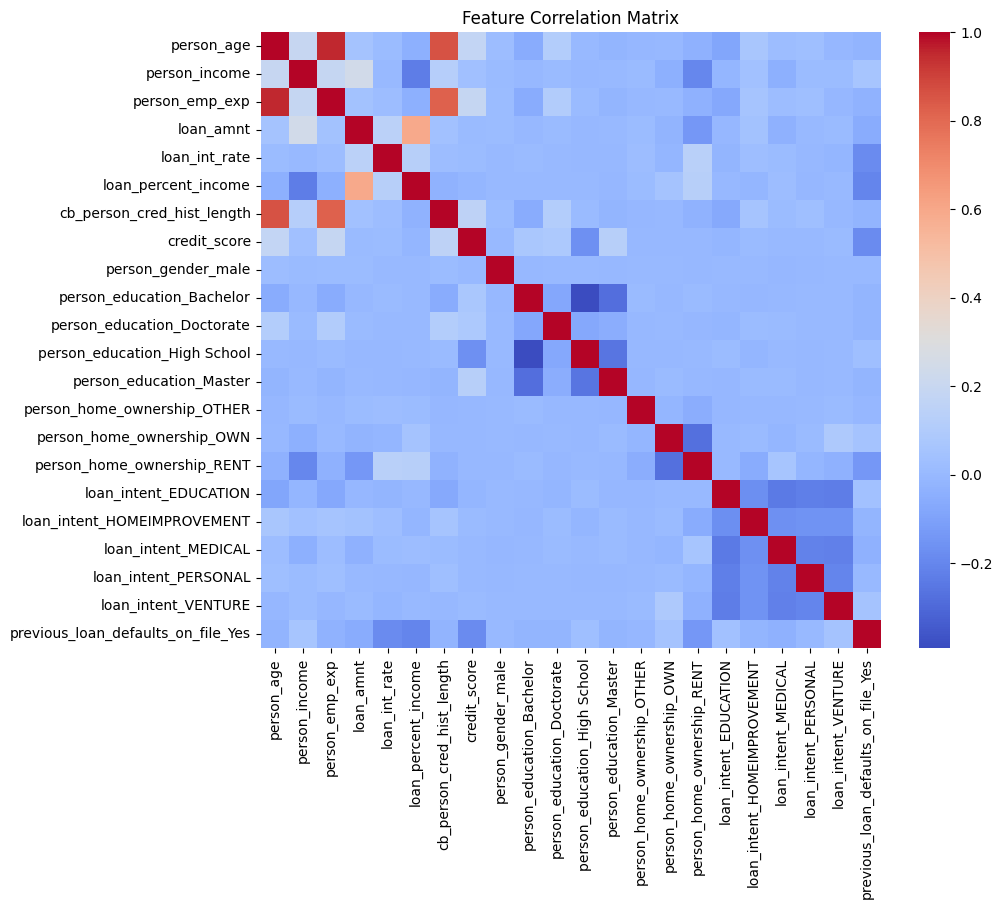

Removed 2 highly correlated features.


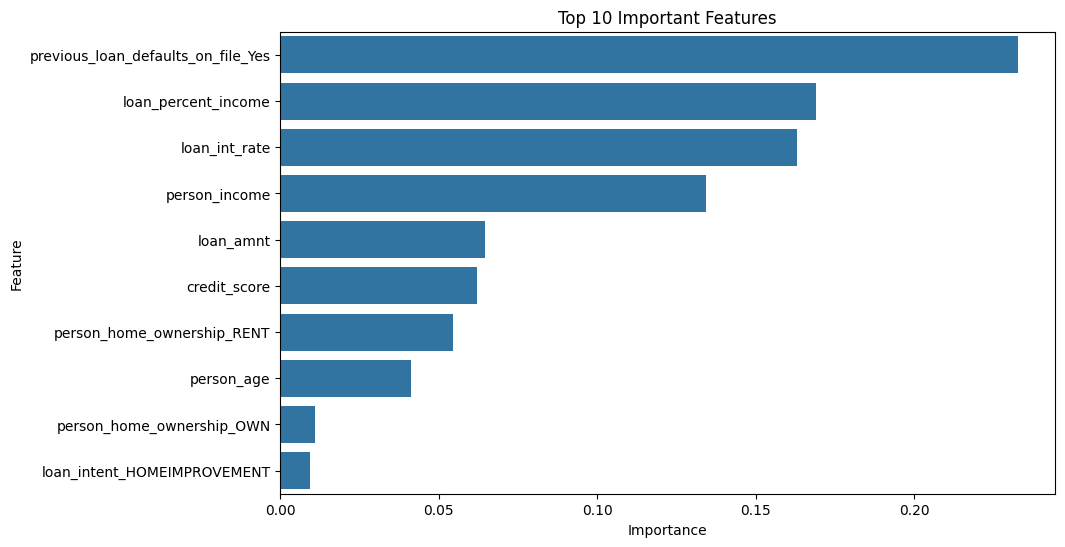

Selected top 10 important features.
Reduced features from 10 to 9 using Variance Threshold.
Feature selection results logged in MLFlow.
🏃 View run Feature Selection Experiment #4 at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/0506daaca5e44c17b50abad950025de9
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
Processed dataset saved.


In [47]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

# Step 1: Load the dataset
data = pd.read_csv('normalized_loan_data.csv')

# Separate features (X) and target (y)
X = data.drop(columns=['loan_status'])  # Replace 'loan_status' with your target column name if different
y = data['loan_status']

# Encode categorical variables (if any)
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Step 2: Perform Feature Selection

## 2.1 Correlation Threshold
correlation_matrix = X_encoded.corr()

# Plot heatmap for visualization (optional)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated features (threshold = 0.85)
threshold = 0.85
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

# Drop highly correlated features
X_corr_filtered = X_encoded.drop(columns=high_corr_features)
print(f"Removed {len(high_corr_features)} highly correlated features.")

## 2.2 Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_corr_filtered, y)

# Get feature importances and sort them in descending order
importance_df = pd.DataFrame({
    'Feature': X_corr_filtered.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance (optional)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Important Features")
plt.show()

# Select top N important features (e.g., top 10)
top_features = importance_df['Feature'].head(10).tolist()
X_important_filtered = X_corr_filtered[top_features]
print(f"Selected top {len(top_features)} important features.")

## 2.3 Variance Threshold
var_thresholder = VarianceThreshold(threshold=0.01)
X_final_filtered = var_thresholder.fit_transform(X_important_filtered)

print(f"Reduced features from {X_important_filtered.shape[1]} to {X_final_filtered.shape[1]} using Variance Threshold.")

# Step 3: Log Results in MLFlow

mlflow.set_experiment("Loan_Classification_Experiment")

with mlflow.start_run(run_name="Feature Selection Experiment #4"):
    # Log parameters and metrics for each method
    mlflow.log_param("Correlation Threshold", threshold)
    mlflow.log_metric("Features Removed by Correlation", len(high_corr_features))
    
    mlflow.log_metric("Top Features Selected by Importance", len(top_features))
    mlflow.log_param("Variance Threshold", 0.01)
    mlflow.log_metric("Final Feature Count", X_final_filtered.shape[1])
    
    # Optionally log artifacts like plots or dataframes
    importance_df.to_csv("feature_importance.csv", index=False)
    mlflow.log_artifact("feature_importance.csv")
    
    print("Feature selection results logged in MLFlow.")

# Step 4: Save Processed Data
pd.DataFrame(X_final_filtered).to_csv('processed_X.csv', index=False)
print("Processed dataset saved.")


# Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. Log results in MLFlow.	10		

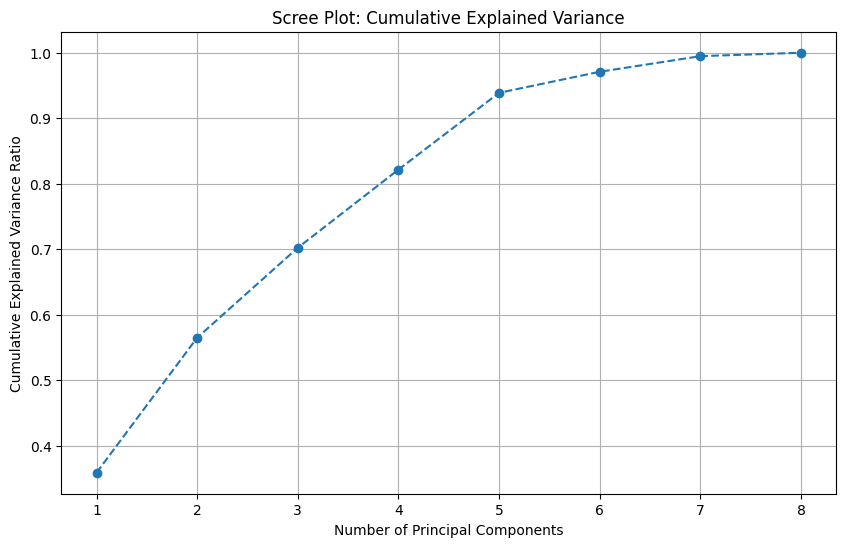

Number of components selected to explain at least 95% variance: 6
PCA results logged in MLFlow.
🏃 View run PCA Experiment #5 at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/efcb4b641ca449e9863fd28ddf262c14
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
Reduced dataset saved as 'pca_reduced_dataset.csv'.


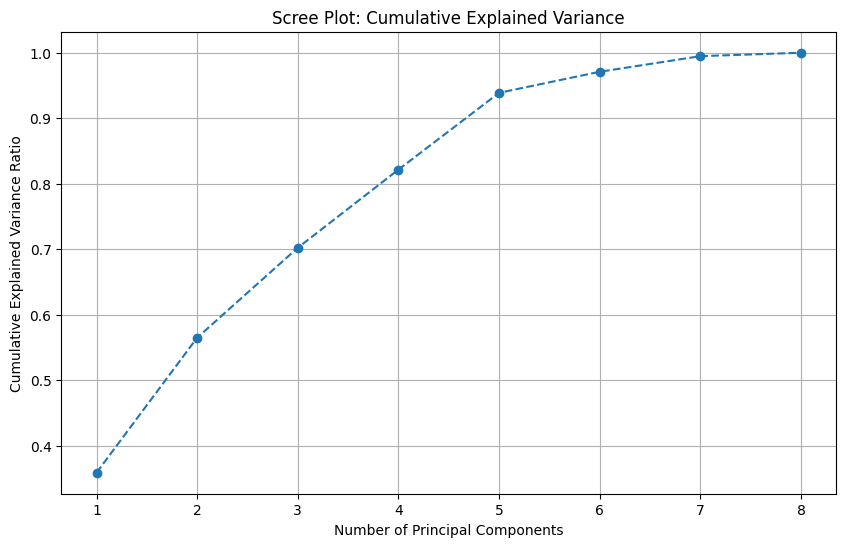

In [48]:

# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import mlflow

# Step 2: Load the dataset
data = pd.read_csv('normalized_loan_data.csv')

# Separate features (X) and target (y)
X = data.drop(columns=['loan_status'])  # Replace 'loan_status' with your target column if different
y = data['loan_status']

# Step 3: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))  # Only numerical columns

# Step 4: Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 5: Scree Plot to visualize explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot: Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()

# Step 6: Select the number of components based on explained variance threshold (e.g., 95%)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components selected to explain at least 95% variance: {n_components}")

# Reduce dimensions using selected components
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)

# Step 7: Log results in MLFlow
mlflow.set_experiment("Loan_Classification_Experiment")

with mlflow.start_run(run_name="PCA Experiment #5"):
    # Log parameters and metrics
    mlflow.log_param("Explained Variance Threshold", 0.95)
    mlflow.log_metric("Number of Components Selected", n_components)
    mlflow.log_metric("Total Variance Explained", cumulative_variance_ratio[n_components - 1])
    
    # Log scree plot as an artifact
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
    plt.title('Scree Plot: Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid()
    scree_plot_path = "scree_plot.png"
    plt.savefig(scree_plot_path)
    mlflow.log_artifact(scree_plot_path)
    
    print("PCA results logged in MLFlow.")

# Step 8: Save the reduced dataset for further modeling
reduced_data = pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(n_components)])
reduced_data['loan_status'] = y.values
reduced_data.to_csv('pca_reduced_dataset.csv', index=False)

print("Reduced dataset saved as 'pca_reduced_dataset.csv'.")


# Experiment #6: Design and execute a custom experiment (Naive Bayes Classifier). Log results in MLFlow.

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import mlflow

# Step 2: Load the dataset
data = pd.read_csv('pca_reduced_dataset.csv')  # Using the PCA-reduced dataset from Experiment #5

# Separate features (X) and target (y)
X = data.drop(columns=['loan_status'])  # Replace 'loan_status' with your target column if different
y = data['loan_status']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y random_state=42)

# Step 4: Train Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = nb_classifier.predict(X_test)

# Step 6: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)

# Confusion Matrix and Classification Report (optional for logging or visualization)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Step 7: Log Results in MLFlow
mlflow.set_experiment("Loan_Classification_Experiment")

with mlflow.start_run(run_name="Naive Bayes Experiment #6"):
    # Log parameters (if any hyperparameters are used)
    mlflow.log_param("Classifier", "Gaussian Naive Bayes")
    
    # Log metrics
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)
    
    # Log confusion matrix as an artifact (optional visualization)
    conf_matrix_path = "confusion_matrix.csv"
    pd.DataFrame(conf_matrix).to_csv(conf_matrix_path, index=False)
    mlflow.log_artifact(conf_matrix_path)
    
    print("Naive Bayes results logged in MLFlow.")

# Step 8: Save Predictions (Optional for further analysis)
predictions_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
predictions_df.to_csv('naive_bayes_predictions.csv', index=False)

print("Predictions saved as 'naive_bayes_predictions.csv'.")


Confusion Matrix:
[[66509  3407]
 [11625  8459]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     69916
           1       0.71      0.42      0.53     20084

    accuracy                           0.83     90000
   macro avg       0.78      0.69      0.71     90000
weighted avg       0.82      0.83      0.82     90000

Naive Bayes results logged in MLFlow.
🏃 View run Naive Bayes Experiment #6 at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/b0bb8b2190ca488ba3e70785822b50ef
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0
Predictions saved as 'naive_bayes_predictions.csv'.


# Experiment #7: Design and execute another custom experiment (Decision Tree). Log results in MLFlow.

In [4]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import dagshub

# Step 2: Load the dataset
data = pd.read_csv('normalized_loan_data.csv')  # Replace with your actual dataset file path

# Separate features (X) and target (y)
X = data.drop(columns=['loan_status'])  # Replace 'loan_status' with your target column if different
y = data['loan_status']

# Step 3: Preprocess Data using ColumnTransformer
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 
                  'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

# Define preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 5: Build Decision Tree Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))  # Limit tree depth for simplicity and efficiency
])

# Step 6: Train the Decision Tree Model
dt_pipeline.fit(X_train, y_train)

# Step 7: Make Predictions
y_pred = dt_pipeline.predict(X_test)

# Step 8: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion Matrix and Classification Report (optional for logging or visualization)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Step 9: Log Results in MLFlow
dagshub.init(repo_owner='Vr1155', repo_name="Loan-Approval-Classification_fall2024", mlflow=True)
# Set MLFlow tracking URI to DagsHub
mlflow.set_tracking_uri("https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow")
mlflow.set_experiment("Loan_Classification_Experiment")

with mlflow.start_run(run_name="Decision Tree Experiment #7"):
    # Log parameters
    mlflow.log_param("Model", "Decision Tree")
    mlflow.log_param("Max Depth", 5)
    
    # Log metrics
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)
    
    print("Decision Tree results logged in MLFlow.")


Confusion Matrix:
[[67492  2508]
 [ 5379 14621]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     70000
           1       0.85      0.73      0.79     20000

    accuracy                           0.91     90000
   macro avg       0.89      0.85      0.87     90000
weighted avg       0.91      0.91      0.91     90000



Accessing as Vr1155

Initialized MLflow to track repo "Vr1155/Loan-Approval-Classification_fall2024"

Repository Vr1155/Loan-Approval-Classification_fall2024 initialized!

Decision Tree results logged in MLFlow.
🏃 View run Decision Tree Experiment #7 at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0/runs/44bedf56abb84ca1a7e6b010b07bde95
🧪 View experiment at: https://dagshub.com/Vr1155/Loan-Approval-Classification_fall2024.mlflow/#/experiments/0


# Create meaningful F1-score plots to compare experiments and determine the best model.	

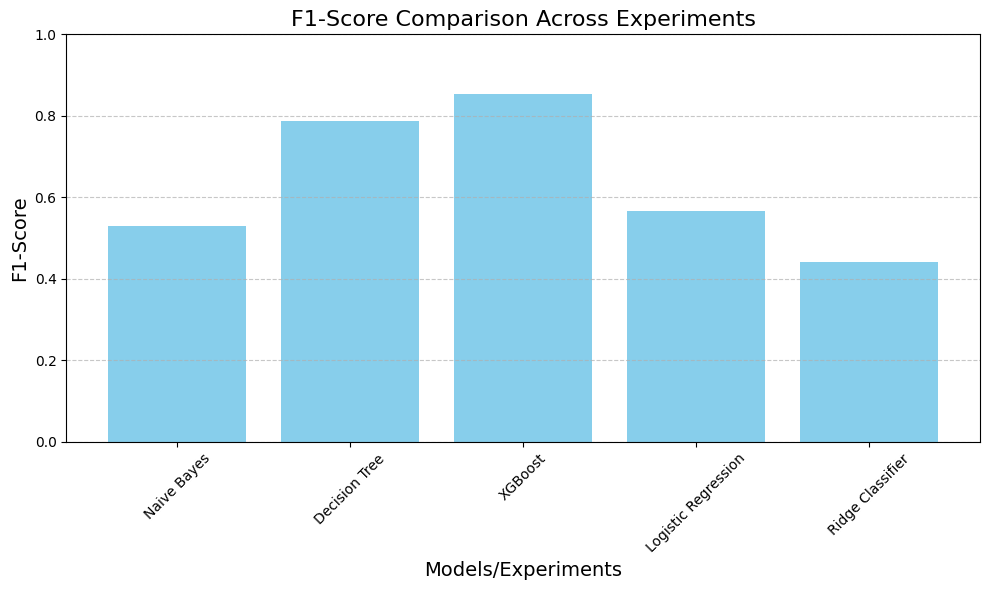

In [13]:
import matplotlib.pyplot as plt
import mlflow

# Correct F1-scores from experiments
f1_scores = {
    "Naive Bayes": 0.5295148669796557, 
    "Decision Tree": 0.7875784427267096,         
    "XGBoost": 0.8534160458611426,  
    "Logistic Regression": 0.5673033808627029,  
    "Ridge Classifier": 0.4423251920066975
}

# Step 1: Create a bar plot for F1-scores
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.title("F1-Score Comparison Across Experiments", fontsize=16)
plt.xlabel("Models/Experiments", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0, 1)  # Set y-axis range to show all scores clearly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save and display the plot
plot_path = "f1_score_comparison_fixed.png"
plt.savefig(plot_path)
plt.show()






# Remaining part of profiling the dataset:

In [17]:
df = pd.read_csv("normalized_loan_data.csv")
from ydata_profiling import ProfileReport

# Generate a profiling report
profile = ProfileReport(df, title="Loan Data Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]